# 1 Project Background

A/B test is a common way for e-commerce website to do user-centered experiements.
In this project, I am going to explore and understand the results of an A/B test run by an e-commerce website. 

Control Group contains the user that landing on the old page, while the treatment Group on the new page.
We gonna analysis conversion rate of each group to get conclusion for decision-making.

## 1.1 Data Understanding and Data Processing

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

In [3]:
df = pd.read_csv("../Web_AB_Test/ab_data.csv")
print("description of dataset: \n",df.describe())
print("\n")
print(df.head())

print("\n")
df.info()

description of dataset: 
              user_id      converted
count  294478.000000  294478.000000
mean   787974.124733       0.119659
std     91210.823776       0.324563
min    630000.000000       0.000000
25%    709032.250000       0.000000
50%    787933.500000       0.000000
75%    866911.750000       0.000000
max    945999.000000       1.000000


   user_id                   timestamp      group landing_page  converted
0   851104  2017-01-21 22:11:48.556739    control     old_page          0
1   804228  2017-01-12 08:01:45.159739    control     old_page          0
2   661590  2017-01-11 16:55:06.154213  treatment     new_page          0
3   853541  2017-01-08 18:28:03.143765  treatment     new_page          0
4   864975  2017-01-21 01:52:26.210827    control     old_page          1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group          

### 1.1.1 Data Understanding

The dataset contains the items of 294478 experiment data, and there are 290584 users participated in the experiment.

- user_id: a unique number to identify each user
- time_stamp: The timestamp of user visits.
- group: The group that user is in. (control group or treatment group)
- landing_page: Which type of page the user was landed. (old_page or new_page)
- converted: whether the user visit resulted in conversion.

We can find that the type of column timestamp is object. For the following time series presenting, here we convert it into datatime64 

In [4]:
df.timestamp=df.timestamp.astype('datetime64[ns]')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null datetime64[ns]
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: datetime64[ns](1), int64(2), object(2)
memory usage: 11.2+ MB


### 1.1.2 Data Processing
To ensure the data used for following analysis is reliable, we need to do the processing, which includes the following steps:
- drop the missing value (we skip this step, because there is no null items in the dataset)
- remove the duplicate item according to user_id
- double check that the treatment group landed on new page and the control group landed on old page.

In [6]:
# Remove the duplicate items
print(df.loc[df.duplicated(["user_id"],keep=False)].user_id)
list=df.loc[df.duplicated(["user_id"],keep=False)].user_id
#df.drop_duplicates(subset = ["user_id"],keep='last')
df1 = df[df.user_id.isin(list)==False]
df1

22        767017
192       656468
226       773693
240       733976
246       704650
           ...  
294308    905197
294309    787083
294328    641570
294331    689637
294355    744456
Name: user_id, Length: 7788, dtype: int64


,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1
...,...,...,...,...,...
294473,751197,2017-01-03 22:28:38.630509,control,old_page,0
294474,945152,2017-01-12 00:51:57.078372,control,old_page,0
294475,734608,2017-01-22 11:45:03.439544,control,old_page,0
294476,697314,2017-01-15 01:20:28.957438,control,old_page,0


In [7]:
df_c = df1[((df1['group'] == 'treatment') & (df1['landing_page'] == 'new_page'))  == True]
df3 =df1[((df1['group'] == 'control') & (df1['landing_page'] == 'old_page'))  == True]
df_c=df_c.append(df3)

df_c

,user_id,timestamp,group,landing_page,converted
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
6,679687,2017-01-19 03:26:46.940749,treatment,new_page,1
8,817355,2017-01-04 17:58:08.979471,treatment,new_page,1
9,839785,2017-01-15 18:11:06.610965,treatment,new_page,1
...,...,...,...,...,...
294471,718310,2017-01-21 22:44:20.378320,control,old_page,0
294473,751197,2017-01-03 22:28:38.630509,control,old_page,0
294474,945152,2017-01-12 00:51:57.078372,control,old_page,0
294475,734608,2017-01-22 11:45:03.439544,control,old_page,0


After the data processing, we removed items with the same user_id and make sure that the user in treatment group landed on new_page while the user in control group landed on old_page.

The items of dataset descrese from 294478 to 286690 after this process.

# 2 Overview of data in each group
In this section, we would have a comparative analysis of control group and treatment group,in terms of the following steps:
- To understand the traffic split of this experiment
- The observed difference on conversion rate, traffic, peak hours of pageview.

In [8]:
control=df_c.loc[df.group=="control"]
print("number of participators in the control group:",control.user_id.nunique())

print(round(control.user_id.nunique()/df_c.user_id.nunique()*100,2),"%")
treatment=df_c.loc[df.group=="treatment"]
print("\nnumber of participators in the treatment group: ",treatment.user_id.nunique())

print(round(treatment.user_id.nunique()/df_c.user_id.nunique()*100,2),"%")

number of participators in the control group: 143293
49.98 %

number of participators in the treatment group:  143397
50.02 %


- There are 147276 users in the treatment group (50.02 %) and 147202 users in the control group (49.98%), the traffic split is around 50/50.

In [23]:
print("Overall conversion rate: ",round(df_c.converted.sum()/df_c.converted.count()*100,4),"%")
print("Conversion rate of treatment group: ",round(treatment.converted.sum()/treatment.converted.count()*100,4),"%")
print("Conversion rate of control group: ",control.converted.sum()/control.converted.count()*100,"%")

Overall conversion rate:  11.945 %
Conversion rate of treatment group:  11.892 %
Conversion rate of control group:  12.039917935897611 %


The overall conversion rate is at 11.945%, and the conversion rate of treatment group and control group is at 11.892% and 12.04%, respectively.

The conversion rate of control group is slightly lower than treatment.

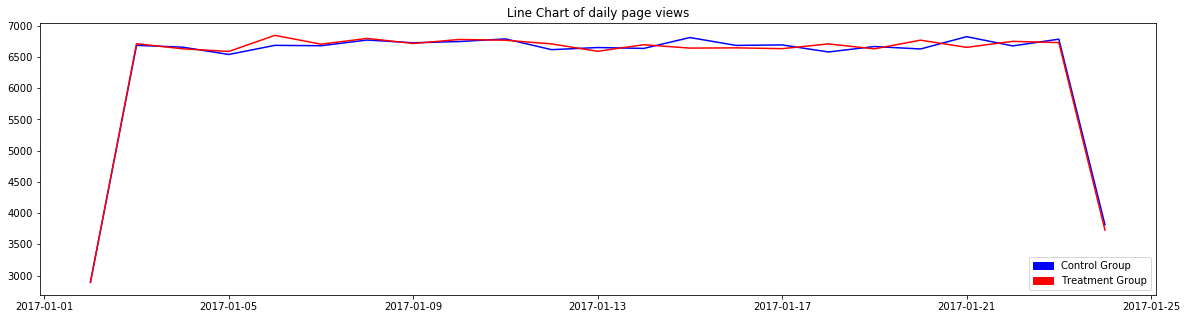

Experiment start time:  2017-01-02 13:42:05.378582
Experiment end time:  2017-01-24 13:41:54.460509


In [15]:
plt.figure(figsize=(20,5))
sns.lineplot(data=control.timestamp.dt.date.value_counts(),color='B')
sns.lineplot(data=treatment.timestamp.dt.date.value_counts(),color='R')
blue_patch = mpatches.Patch(color='red', label='Treatment Group')
red_patch = mpatches.Patch(color='blue', label='Control Group')
plt.legend(handles=[red_patch,blue_patch])

plt.title("Line Chart of daily page views")

plt.show()
print("Experiment start time: ",df_c.timestamp.min())
print("Experiment end time: ",df_c.timestamp.max())

- The experiment started from 02/01/2017 at 13:42:05 and ended on at 24/01/2017 13:41:54 lasting for 22 days.

- From the line chart above, we can see that from January 2, 2017, to January 24, 2017, the daily traffic of the website was remained at 13,000 times per day (6000 times each group). The pageview was abnormally low at the start date and end date of the experiment, and it is caused by the start time and end time of the experiment, which lead to the incomplete collection of data.

- There is not an obvious difference in daily pageview between control group and treatment group.

In [11]:
print("minimum of pageview：",df_c.timestamp.dt.hour.value_counts().min())
print("maximum of pageview：",df_c.timestamp.dt.hour.value_counts().max())
print("mean of pageview：",df_c.timestamp.dt.hour.value_counts().mean())

minimum of pageview： 11717
maximum of pageview： 12096
mean of pageview： 11945.416666666666


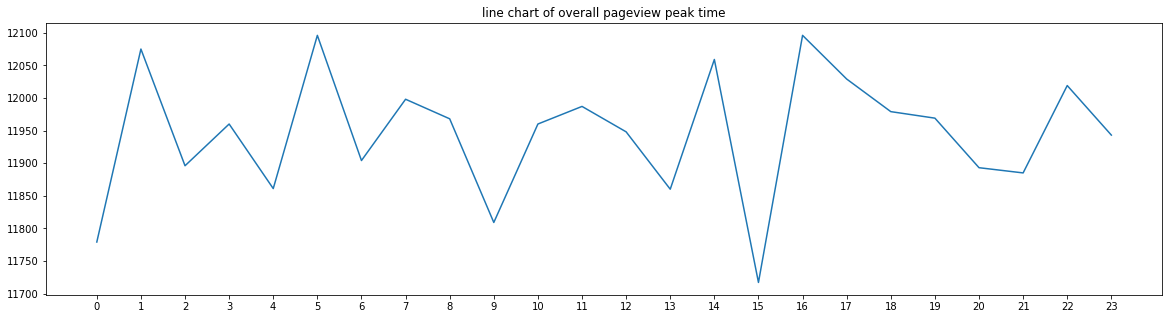

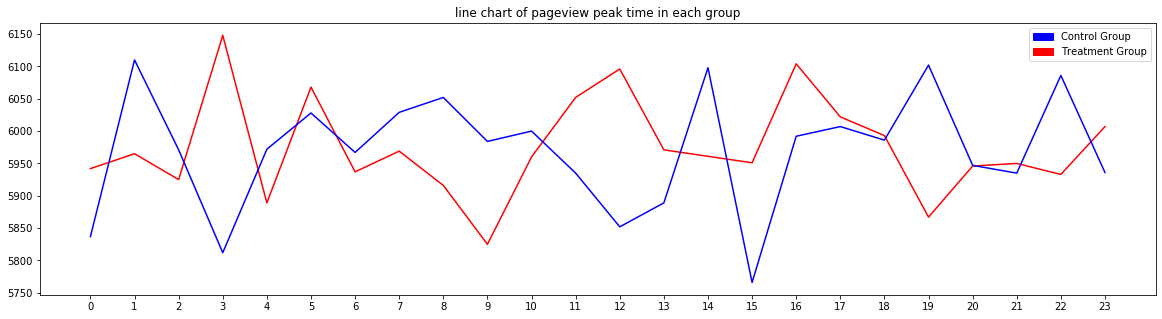

Experiment start time:  2017-01-02 13:42:05.378582
Experiment end time:  2017-01-24 13:41:54.460509


In [12]:
plt.figure(figsize=(20,5))
sns.lineplot(data=df_c.timestamp.dt.hour.value_counts())
plt.title("line chart of overall pageview peak time")
plt.xticks(np.arange(0,24,1))
plt.show()

plt.figure(figsize=(20,5))
sns.lineplot(data=treatment.timestamp.dt.hour.value_counts(),color="red")
sns.lineplot(data=control.timestamp.dt.hour.value_counts(),color="blue")
blue_patch = mpatches.Patch(color='red', label='Treatment Group')
red_patch = mpatches.Patch(color='blue', label='Control Group')
plt.legend(handles=[red_patch,blue_patch])
plt.title("line chart of pageview peak time in each group")
plt.xticks(np.arange(0,24,1))
plt.show()
print("Experiment start time: ",df.timestamp.min())
print("Experiment end time: ",df.timestamp.max())

- The pageview per hour during the day shows a mean of 11945. The period with the highest number of pageview is from 16:00 to 17:00, which has 12096 times in total. The period with the lowest number of pageview is from 15:00 to 16:00, which has 11717 times in total.This might because of the user's daily routine, but not a big fluctuation. However, there is no significant peak hours in website pageview.

- It's worthy to notice that the treatment group shows different trends from the control group around 3:00,12:00 and 16:00.

# 3. A/B Test
Based on the analysis above, we can get the conversion rate of treatment group and control group is at 11.892% and 12.04%, respectively.
The difference of probability between control and treatment groups is tiny. Therefore, we still need more evidence to assess the performance of treatment group.There is a need to conduct a hypothesis test.

#### Null Hypothesis: There is no difference between the control and experiment group.
-   P new - P old <= 0
  
#### Alternate Hypothesis: There is difference between the control and experiment group.
-   P new - P old > 0



In [21]:
print("size of control group: ",control.count()['user_id'])
print("size of treatment group: ",treatment.count()['user_id'])
n_new = treatment.count()['user_id']
n_old = control.count()['user_id']


size of control group:  147202
size of treatment group:  147276


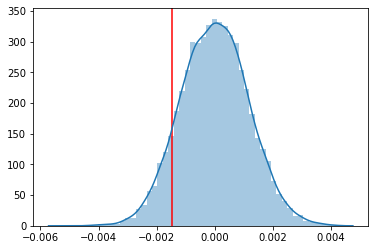

In [31]:
def perm_fun(n,size1,size2):
    np.random.shuffle(n)
    n1=n[:size1]
    n2=n[-size2:]
    return n1.mean()-n2.mean()

num=10000
obs_diff=treatment.converted.mean()-control.converted.mean()
diff=[]
n=np.array(df_c.converted)
for i in range(num):
    diff.append(perm_fun(n,n_new,n_old))
    
plt.axvline(x=obs_diff,c='r')
sns.distplot(diff)

In [32]:
print("The propotion of obs_diff >",(diff>obs_diff).mean())

0.9006